In [ ]:
!nvidia-smi

Sun Jun  5 07:47:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Memeriksa CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# Melakukan cloning data
!git clone https://github.com/Soedirman-Machine-Learning/face-mask-detection.git

Cloning into 'face-mask-detection'...
remote: Enumerating objects: 4737, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 4737 (delta 19), reused 35 (delta 19), pack-reused 4701
Receiving objects: 100% (4737/4737), 469.11 MiB | 43.41 MiB/s, done.
Resolving deltas: 100% (119/119), done.
Checking out files: 100% (4424/4424), done.


In [ ]:
# Berpindah ke folder face-mask-detection
%cd face-mask-detection/

# Memeriksa isi folder face-mask-detection
!ls

/content/face-mask-detection
'aplikasi android'
 Aplikasi-Android.gif
'berkas tugas akhir'
 dataset
 face-detector.zip
 Face_Mask_Detection_MobileNetV2_with_MTCNN.ipynb
 Face_Mask_Detection_MobileNetV2_with_ResNet10.ipynb
 Face_Mask_Detection_VGG16Net_with_MTCNN.ipynb
 Face_Mask_Detection_VGG16Net_with_ResNet10.ipynb
 Full_Face_Mask_Detection_MobileNetV2.ipynb
 Full_Face_Mask_Detection_VGG16Net.ipynb
 logo-md1png.png
 mask_model.tflite
 pengujian
 README.md


In [ ]:
# Melakukan unzip pada folder face-detector.zip
!unzip face-detector.zip

Archive:  face-detector.zip
  inflating: deploy.prototxt         
  inflating: example_img/ex01.jpg    
  inflating: example_img/ex02.jpg    
  inflating: example_img/ex03.jpg    
  inflating: example_img/ex04.jpg    
  inflating: example_img/ex05.jpg    
  inflating: example_img/ex06.jpg    
  inflating: example_img/ex07.jpg    
  inflating: example_img/ex08.jpg    
  inflating: example_img/ex09.jpg    
  inflating: example_img/ex10.jpg    
  inflating: res10_300x300_ssd_iter_140000.caffemodel  


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools
 
# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime
 
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 190 µs (started: 2022-06-05 08:00:20 +00:00)


In [ ]:
# Memeriksa Versi TensorFlow
print(tf.__version__)

2.8.2
time: 1.62 ms (started: 2022-06-05 08:00:49 +00:00)


In [ ]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch pelatihan, dan Batch Size
INIT_LR = 1e-4
EPOCHS = 30
BS = 32
 
# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
 
# Melakukan perulangan pada image paths
for imagePath in imagePaths:
 
    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
 
    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)
 
# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Input gambar berhasil")

Menginput gambar...


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Input gambar berhasil
time: 18.2 s (started: 2022-06-05 08:13:37 +00:00)


In [ ]:
# Mempartisi data ke dalam pelatihan dan pengujian (75% : 25%)
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.25, stratify=labels, random_state=42)
 
# Membentuk training image generator untuk data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

time: 529 ms (started: 2022-06-05 08:34:47 +00:00)


In [ ]:
# Arsitektur jaringan MobileNetV2
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step
time: 4.98 s (started: 2022-06-05 08:36:27 +00:00)


In [ ]:
baseModel.trainable = False
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
 
# Perulangan pada seluruh base model
for layer in baseModel.layers:
    layer.trainable = False
 
# Persiapan kompilasi model
print("Mengkompilasi model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

model.summary()

Mengkompilasi model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                                                  
 block_4_depthwise (DepthwiseCo  (None, 28, 28, 192)  1728       ['block_4_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_4_depthwise_BN (BatchNor  (None, 28, 28, 192)  768        ['block_4_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_4_depthwise_relu (ReLU)  (None, 28, 28, 192)  0           ['block_4_depthwise_BN[0][0]']   
                                                                                                  
 block_4_project (Conv2D)       (None, 28, 28, 32)   6144        ['block_4_depthwise_relu[0][0]'] 
          

In [ ]:
# Pelatihan model
print("Training head model...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training head model...
Epoch 1/30
89/89 [==============================] - 44s 352ms/step - loss: 0.3894 - accuracy: 0.8681 - val_loss: 0.1649 - val_accuracy: 0.9698
Epoch 2/30
89/89 [==============================] - 30s 333ms/step - loss: 0.1459 - accuracy: 0.9627 - val_loss: 0.0952 - val_accuracy: 0.9812
Epoch 3/30
89/89 [==============================] - 30s 332ms/step - loss: 0.0983 - accuracy: 0.9768 - val_loss: 0.0710 - val_accuracy: 0.9854
Epoch 4/30
89/89 [==============================] - 30s 332ms/step - loss: 0.0748 - accuracy: 0.9806 - val_loss: 0.0616 - val_accuracy: 0.9812
Epoch 5/30
89/89 [==============================] - 30s 333ms/step - loss: 0.0655 - accuracy: 0.9810 - val_loss: 0.0535 - val_accuracy: 0.9844
Epoch 6/30
89/89 [==============================] - 30s 342ms/step - loss: 0.0541 - accuracy: 0.9835 - val_loss: 0.0482 - val_accuracy: 0.9844
Epoch 7/30
89/89 [==============================] - 30s 334ms/step - loss: 0.0542 - accuracy: 0.9845 - val_loss: 0.0443

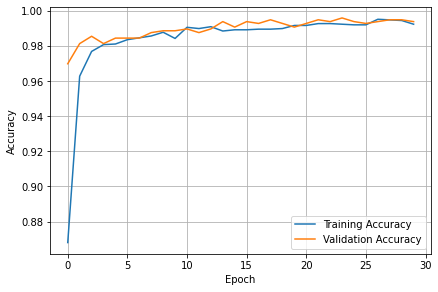

time: 201 ms (started: 2022-06-05 09:05:24 +00:00)


In [ ]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(zorder = 0)

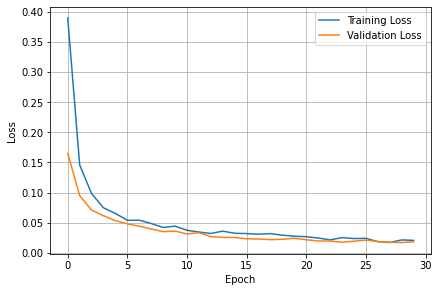

time: 144 ms (started: 2022-06-05 09:05:41 +00:00)


In [ ]:
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(zorder = 0)
plt.show()

In [ ]:
# Memeriksa matriks model
print(model.metrics_names)
# Evaluasi data test
print(model.evaluate(x= testX, y = testY))

['loss', 'accuracy']
30/30 [==============================] - 3s 106ms/step - loss: 0.0224 - accuracy: 0.9937
[0.02240067720413208, 0.9937434792518616]
time: 3.76 s (started: 2022-03-25 10:19:10 +00:00)


In [ ]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

[1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1
 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1
 0 0 1 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1
 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0
 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1
 1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0
 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1
 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 1
 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 1 1 1
 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1
 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1
 1 0 0 1 0 1 0 1 0 1 0 0 

In [ ]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue)) 
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

time: 4.1 ms (started: 2022-03-25 10:19:35 +00:00)


In [ ]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[477,   2],
       [  4, 476]])

time: 7.21 ms (started: 2022-03-25 10:19:40 +00:00)


Text(0.5, 15.0, 'Prediction Label')

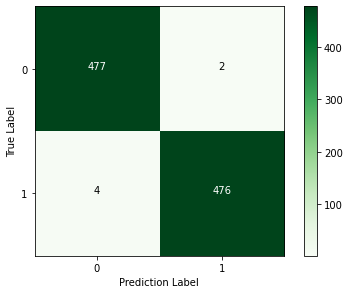

time: 287 ms (started: 2022-03-25 10:19:44 +00:00)


In [ ]:
classes = [0, 1]

# Plotting confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
# plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Prediction Label')

In [ ]:
# Berdasarkan confusion matrix
TP = true_pos = 476
TN = true_neg = 477
FP = false_pos = 2
FN = false_neg = 4

time: 8.98 ms (started: 2022-03-25 10:23:40 +00:00)


In [ ]:
results = {}

# Akurasi
metric = "Akurasi"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Recall
metric = "Recall"
results[metric] = TP / (TP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Presisi
metric = "Presisi"
results[metric] = TP / (TP + FP)
print(f"{metric} = {results[metric]: .3f}")

# Nilai F1
metric = "F1"
results[metric] = 2 / (1 / results["Presisi"] + 1 / results["Recall"])
print(f"{metric} = {results[metric]: .3f}")

Akurasi =  0.994
Recall =  0.992
Presisi =  0.996
F1 =  0.994
time: 13.3 ms (started: 2022-03-25 10:23:42 +00:00)


In [ ]:
# Membuat prediksi dari pengujian
predIdxs = model.predict(testX, batch_size=BS)
 
# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 
# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       479
without_mask       1.00      0.99      0.99       480

    accuracy                           0.99       959
   macro avg       0.99      0.99      0.99       959
weighted avg       0.99      0.99      0.99       959

time: 2.82 s (started: 2022-03-25 10:23:54 +00:00)


In [ ]:
export_dir='saved_models/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_models/1/assets
time: 18.1 s (started: 2022-03-25 10:24:48 +00:00)


In [ ]:
# Mengkonvert model ke format tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

time: 12.3 s (started: 2022-03-25 10:25:09 +00:00)


In [ ]:
# Menyimpan model
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

9516052

time: 21.8 ms (started: 2022-03-25 10:25:24 +00:00)


In [ ]:
# Memuat model dan mengalokasikan ke tensor
interpreter = tf.lite.Interpreter(model_content = tflite_model)
interpreter.allocate_tensors()

# Mendapatkan input dan ouput tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

print(input_details)
print(output_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 181, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
time: 61.4 ms (started: 2022-03-25 10:25:27 +00:00)


In [ ]:
model.save("/content/simpan_model/model_work.h5")

time: 381 ms (started: 2022-03-07 05:22:15 +00:00)


In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("/content/simpan_model/mask_detector.model", save_format="h5")

[INFO] saving mask detector model...
time: 438 ms (started: 2022-03-25 10:25:57 +00:00)


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

time: 5.92 ms (started: 2022-03-25 10:26:08 +00:00)


In [ ]:
!wget -O 'mask.jpg' 'https://asset.kompas.com/crops/ny5In331C8aFbzcqvZdRVav-8x0=/0x0:1999x1333/750x500/data/photo/2020/05/29/5ed0a6472e792.jpg'

--2022-03-25 10:26:11--  https://asset.kompas.com/crops/ny5In331C8aFbzcqvZdRVav-8x0=/0x0:1999x1333/750x500/data/photo/2020/05/29/5ed0a6472e792.jpg
Resolving asset.kompas.com (asset.kompas.com)... 108.156.107.2, 108.156.107.59, 108.156.107.13, ...
Connecting to asset.kompas.com (asset.kompas.com)|108.156.107.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19644 (19K) [image/jpeg]
Saving to: ‘mask.jpg’

mask.jpg            100%[===================>]  19.18K  --.-KB/s    in 0.001s  

2022-03-25 10:26:11 (29.4 MB/s) - ‘mask.jpg’ saved [19644/19644]

time: 315 ms (started: 2022-03-25 10:26:11 +00:00)


Mendeteksi wajah...


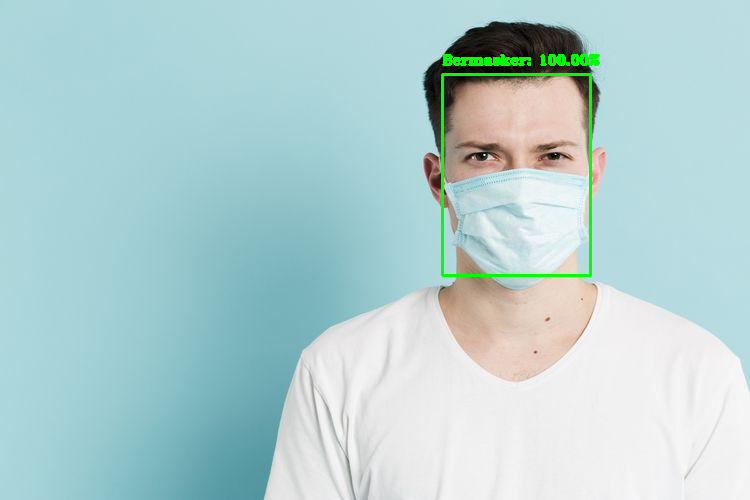

-1

time: 1.1 s (started: 2022-03-25 10:26:15 +00:00)


In [ ]:
image = cv2.imread('/content/face-mask-detection/mask.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

net=cv2.dnn.readNet('/content/face-mask-detection/deploy.prototxt','/content/face-mask-detection/res10_300x300_ssd_iter_140000.caffemodel')

# Melewatkan blob melalui jaringan dan mendapatkan deteksi wajah
print("Mendeteksi wajah...")
net.setInput(blob)
detections = net.forward()

for i in range(0, detections.shape[2]):
	# ekstrak keyakinan (yaitu, probabilitas) yang terkait dengan deteksi
	confidence = detections[0, 0, i, 2]

	if confidence > 0.5:
		# Menghitung koordinat (x, y) dari kotak pembatas untuk objek
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# Memastikan kotak pembatas berada dalam dimensi bingkai
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
    # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# Membaca wajah dengan model
		(mask, withoutMask) = model.predict(face)[0]

		# Menggunakan masker hijau, tidak bermasker merah
		label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
		color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# Probabilitas hasil deteksi
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# Menampilkan hasil dengan label dan kotak
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_TRIPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# Menampilkan output
cv2_imshow(image)
cv2.waitKey(0)